**Day 2 - June 3 2022**

| Student                       | ID        |
| -------------                 |:---------:|
| Benjamin Starostka Jakobsen   | s184198   |
| Muhammad REDACTED             | REDACTED  |
| Victor REDACTED               | REDACTED  |

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import chi2

sns.set_style("white")

# Exercise 2
# Discrete random variables

**In the excercise you can use a build in procedure for generating random numbers. Compare the results obtained in simulations with expected results. Use histograms (and tests).**

## 1. 
**Choose a value for the probability parameter $p$ in the geometric distribution and simulate 10,000 outcomes. You can experiment with a small, moderate and large value if you like.**

$$
X = |\_\frac{\log(U)}{\log(1-p)}\_| + 1
$$

In [ ]:
def generate_geometric_distr(p, N):
    U = np.random.uniform(low=0.0, high=1.0, size=N)
    X = []
    for u in U:
        X += [int(np.floor(np.log(u) / np.log(1 - p)) + 1)]
    return X

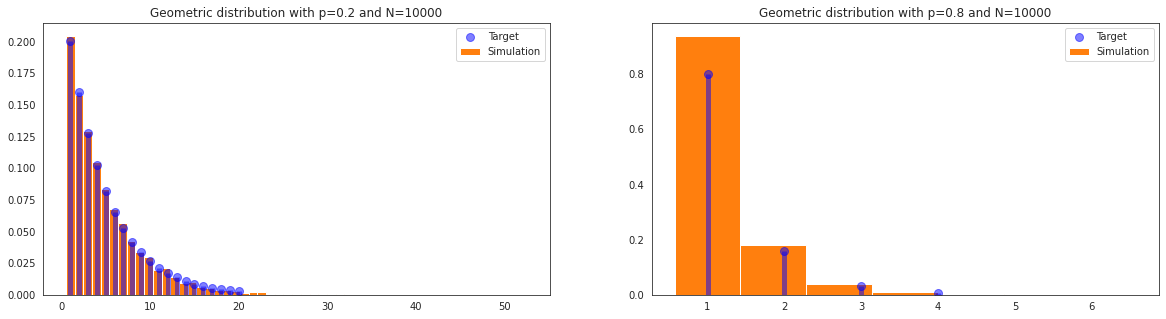

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

N = 10000
# First experiment, low p
p = 0.2
X1 = generate_geometric_distr(p, N)

x = np.arange(stats.geom.ppf(0.01, p), stats.geom.ppf(0.99, p))
axes[0].plot(x, stats.geom.pmf(x, p), "bo", ms=8, label="Target", alpha=0.5)
axes[0].vlines(x, 0, stats.geom.pmf(x, p), colors="b", lw=5, alpha=0.5)
n1, bins1, _ = axes[0].hist(
    X1, bins=max(X1), density=True, label="Simulation", align="left", color="C1"
)
axes[0].set(title=f"Geometric distribution with p={p} and N={N}")
axes[0].legend()

# Second experiment, high p
p = 0.8
X2 = generate_geometric_distr(p, N)

x = np.arange(stats.geom.ppf(0.001, p), stats.geom.ppf(0.999, p))
axes[1].plot(x, stats.geom.pmf(x, p), "bo", ms=8, label="Target", alpha=0.5)
axes[1].vlines(x, 0, stats.geom.pmf(x, p), colors="b", lw=5, alpha=0.5)
n2, bins2, _ = axes[1].hist(
    X2, bins=max(X2), density=True, label="Simulation", align="left", color="C1"
)
axes[1].set(title=f"Geometric distribution with p={p} and N={N}")
axes[1].legend()

plt.show()

Visually, when comparing the probability mass function of the geomtric distribution with the histogram density of the samples, we see that they look very similar.

### $\chi^2$-test

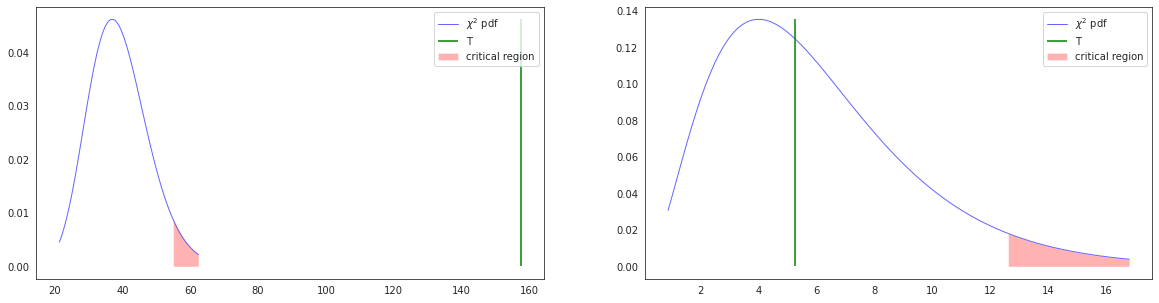

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for p, X in zip([0.2, 0.8], [X1, X2]):
    values, counts = np.unique(X, return_counts=True)
    T = 0
    for val, obs in zip(values, counts):
        exp = stats.geom.pmf(val, p=p) * N
        T += (obs - exp) ** 2 / exp

    df = len(values) - 1
    x = np.linspace(stats.chi2.ppf(0.01, df), stats.chi2.ppf(0.99, df), 100)
    y = stats.chi2.pdf(x, df)

    ax = axes[0] if p == 0.2 else axes[1]
    ax.plot(x, y, "b-", lw=1, alpha=0.6, label=r"$\chi^2$ pdf")
    ax.vlines(x=T, ymin=0, ymax=max(y), color="green", label="T")
    ax.fill_between(
        x,
        0,
        y,
        where=x >= stats.chi2.ppf(0.95, df),
        facecolor="red",
        alpha=0.3,
        interpolate=True,
        label="critical region",
    )
    ax.legend()

plt.show()

The $\chi^2$ tests show that the null hypothesis, i.e. the samples follow a geometric distribution, is not rejected. 

## 2. 
**Simulate the 6 point distribution with**

P(X=1) = 7/48,

P(X=2) = 5/48

P(X=3) = 1/8

P(X=4) = 1/16

P(X=5) = 1/4

P(X=6) = 5/16

In [ ]:
k = 6
probs = np.array([7 / 48, 5 / 48, 1 / 8, 1 / 16, 1 / 4, 5 / 16])
N = 10000

### (a) Direct (crude) method

In [ ]:
# Explicit implementation:
U = np.random.uniform(low=0.0, high=1.0, size=N)
Ps = [7 / 48, 5 / 48, 1 / 8, 1 / 16, 1 / 4, 5 / 16]
Xa = []
classes = len(Ps)
for i in range(len(U)):
    for j in range(1, len(Ps) + 1):
        if j == 1 and (U[i] > 0 and U[i] <= Ps[:j]):
            Xa += [1]
        else:
            if U[i] > np.sum(Ps[: j - 1]) and U[i] <= np.sum(Ps[:j]):
                Xa += [j]

In [ ]:
# "Optimized" implementation:


def generate_crude_method(k, probs, N):
    probs_cumu = np.cumsum(probs)
    U = np.random.uniform(low=0.0, high=1.0, size=N)
    X = []
    for i in range(N):
        indices = np.argwhere(probs_cumu >= U[i]).flatten()
        # The class is the first interval that u falls into, i.e. the first index in indices (+ 1 bc python indexing)
        X += [indices[0] + 1]

    return X


# Xa = generate_crude_method(k, probs, N)

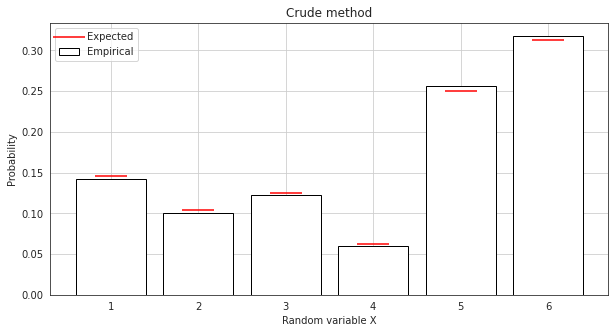

In [ ]:
values, counts = np.unique(Xa, return_counts=True)
probs_empirical = counts / N

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    x=values,
    height=probs_empirical,
    color="white",
    edgecolor="black",
    label="Empirical",
)
ax.scatter(values, probs, marker="_", color="red", s=1000, label="Expected")
ax.set(title="Crude method", xlabel="Random variable X", ylabel="Probability")
ax.legend()
plt.grid()
plt.show()

### (b) Rejection method

In [ ]:
def generate_rejection_method(k, probs, N):
    c = max(probs)
    X = []
    while len(X) < N:
        u1 = np.random.uniform()
        I = int(np.floor(k * u1) + 1)

        u2 = np.random.uniform()
        if u2 < probs[I - 1] / c:
            X += [I]

    return X


Xb = generate_rejection_method(k, probs, N)

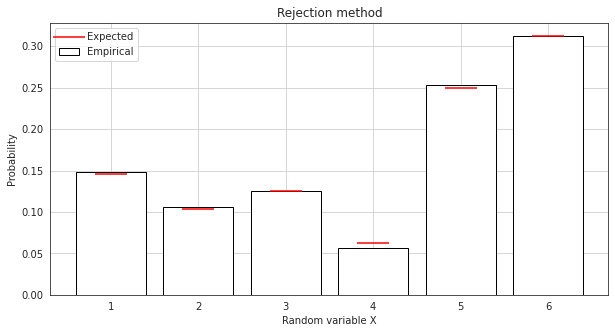

In [ ]:
values, counts = np.unique(Xb, return_counts=True)
probs_empirical = counts / N

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    x=values,
    height=probs_empirical,
    color="white",
    edgecolor="black",
    label="Empirical",
)
ax.scatter(values, probs, marker="_", color="red", s=1000, label="Expected")
ax.set(title="Rejection method", xlabel="Random variable X", ylabel="Probability")
plt.grid()
plt.legend()
plt.show()

### (c) Alias method

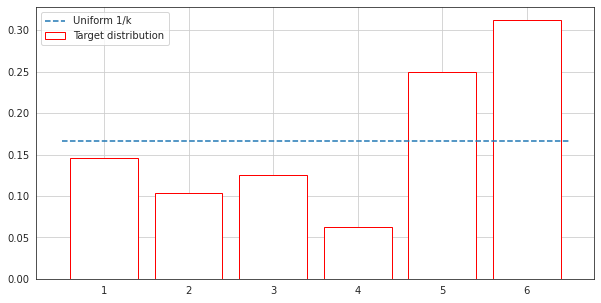

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    x=np.arange(1, 6 + 1),
    height=probs,
    color="white",
    edgecolor="red",
    label="Target distribution",
)
ax.hlines(y=1 / 6, xmin=0.5, xmax=6.5, ls="--", label="Uniform 1/k")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Deriving the tables by hands:
F = probs / (1 / 6)  # which part of the mass belongs to I itself.
print("Proportion of mass:", F)
F = np.clip(F, 0, 1)
print("Clipped F:", F)
print("Gap between probs and 1/6:", probs - (1 / 6))
L = np.array([5, 5, 6, 6, 5, 6])
print("Labels/Aliases:", L)

Proportion of mass: [0.875 0.625 0.75  0.375 1.5   1.875]
Clipped F: [0.875 0.625 0.75  0.375 1.    1.   ]
Gap between probs and 1/6: [-0.02083333 -0.0625     -0.04166667 -0.10416667  0.08333333  0.14583333]
Labels/Aliases: [5 5 6 6 5 6]


In [ ]:
# Generating tables with algorithm (using pseudo-code in slides)


def set_up_F_L_tables(k, probs):
    L = np.arange(1, k + 1)
    F = k * probs
    G = np.argwhere(F >= 1).flatten() + 1
    S = np.argwhere(F <= 1).flatten() + 1
    while len(S) > 0:
        # L, G and S contains the classes, so number in {1,....,k}
        # But accessing those arrays need to be done with index-1 (python indexing starts at 0)
        i = G[0]
        j = S[0]
        L[j - 1] = i
        F[i - 1] = F[i - 1] - (1 - F[j - 1])
        if F[i - 1] < 1:
            G = G[1:]
            S = np.append(S, [i])
        S = S[1:]

    return F, L

In [ ]:
def generate_alias_method(k, probs, N):
    F, L = set_up_F_L_tables(k, probs)
    print("F:", F)
    print("L:", L)

    X = []
    while len(X) < N:
        u1 = np.random.uniform()
        I = int(np.floor(k * u1) + 1)

        u2 = np.random.uniform()
        if u2 < F[I - 1]:
            X += [I]
        else:
            X += [L[I - 1]]

    return X


Xc = generate_alias_method(k, probs, N)

F: [0.875 0.625 0.75  0.375 0.75  1.   ]
L: [5 5 5 6 6 6]


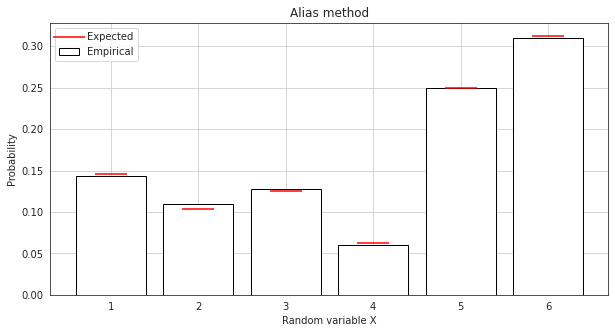

In [ ]:
values, counts = np.unique(Xc, return_counts=True)
probs_empirical = counts / N

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    x=values,
    height=probs_empirical,
    color="white",
    edgecolor="black",
    label="Empirical",
)
ax.scatter(values, probs, marker="_", color="red", s=1000, label="Expected")
ax.set(title="Alias method", xlabel="Random variable X", ylabel="Probability")
plt.grid()
plt.legend()
plt.show()

## 3. 

**Compare the three different methods using adequate criteria,
then discuss the results.**

### $\chi^2$-test

In [ ]:
def chi_square_statistic(k, n_observed, n_expected):
    T = 0
    for i in range(k):
        T += (n_observed[i] - n_expected[i]) ** 2 / n_expected[i]
    return T

In [ ]:
# Expected and observed counts
n_expected = probs * N
_, n_observed_a = np.unique(Xa, return_counts=True)
_, n_observed_b = np.unique(Xb, return_counts=True)
_, n_observed_c = np.unique(Xc, return_counts=True)

# Test statistics for each methods a, b and c.
Ta = chi_square_statistic(k, n_observed_a, n_expected)
Tb = chi_square_statistic(k, n_observed_b, n_expected)
Tc = chi_square_statistic(k, n_observed_c, n_expected)

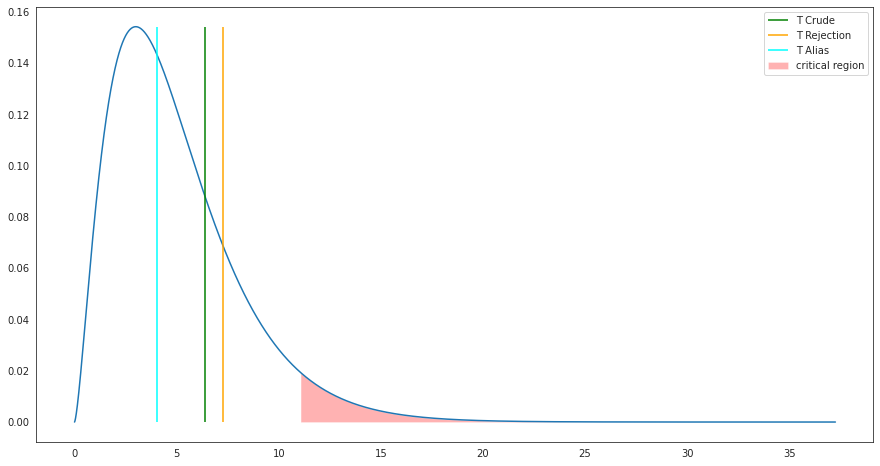

T critical 11.070497693516351
Crude p value  = 0.2696292877439912
Rejection p value  = 0.20181688154583033
Alias p value  = 0.5447540865264442


In [ ]:
df = (
    k - 1 - 0
)  # Degrees of freedom = nclasses − 1 − the number of estimated parameters.
x_coord = np.linspace(0, max(Ta, Tb, Tc) + 30, num=10000)
y = chi2.pdf(x_coord, df)

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(x_coord, y)
plt.vlines(x=Ta, ymin=0, ymax=max(y), color="green", label="T Crude")
plt.vlines(x=Tb, ymin=0, ymax=max(y), color="orange", label="T Rejection")
plt.vlines(x=Tc, ymin=0, ymax=max(y), color="cyan", label="T Alias")
ax.fill_between(
    x_coord,
    0,
    y,
    where=x_coord >= chi2.ppf(0.95, df),
    facecolor="red",
    alpha=0.3,
    interpolate=True,
    label="critical region",
)
ax.legend()
plt.show()

p_value_a = 1 - chi2.cdf(Ta, df)
p_value_b = 1 - chi2.cdf(Tb, df)
p_value_c = 1 - chi2.cdf(Tc, df)
print("T critical", chi2.ppf(0.95, df))
print("Crude p value  =", p_value_a)
print("Rejection p value  =", p_value_b)
print("Alias p value  =", p_value_c)

## 4.
**Give recommendations of how to choose the best suited
method in different settings, i.e., discuss the advantages and
drawbacks of each method. If time permits substantiate by
running experiments.**


- Crude method: if k is large (k>>), looping over the list of probabilities of length $k$ and computing the sums of its subsets become computationally very expensive.
- Rejection method: generates a lot of numbers, waste of time/memory.
- Alias method: probably the best, because it generates 2 random numbers per random variable (not more, not less). However, setting it up (the tables F and L) is a bit complicated. Could be prone to mistakes. Moreover, there is multiple possible pairs of F-L tables possible.